# FEQL for hard rod (hard sphere in 1D) pytorch prototype

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
except:
    pass

In [2]:
#Choose GPU pr cpu
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [3]:
import torch
from torch.autograd import grad
torch.autograd.set_detect_anomaly(True)
#torch.cuda.current_device()
from torch.utils.data import DataLoader,TensorDataset
device = 'cpu'
if(torch.cuda.is_available()):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device='cuda'
import torch.distributed as dist

In [4]:
# general imports 
from scipy.integrate import simps
from numpy import exp, absolute
from numpy import exp, asarray, empty
from numpy import zeros, array, float, random
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile
import time
import pickle

In [5]:
import sympy
from sympy import Matrix
from sympy import symbols
from sympy import diff

In [6]:
from utility import load_data,train_val_data,train_varible

## load data

In [7]:
path_to_file = '../HR_data/'
L,N,dx,batch_size,MC_inform = load_data(path_to_file)
input_shape = (N,1)

In [8]:
rho_train, rho_test ,c1_HR_train, c1_HR_test,Vext_train, \
Vext_test,eps_train,eps_test, mu_train, mu_test, deltaF_train, deltaF_test = train_val_data(path_to_file,N,MC_inform)

### convert data to train_val tensor

In [9]:
train_dataset = TensorDataset(torch.from_numpy(rho_train),torch.from_numpy(Vext_train),torch.from_numpy(mu_train))
train_loader=DataLoader(train_dataset,batch_size=64, shuffle=True)
val_dataset = TensorDataset(torch.from_numpy(rho_test),torch.from_numpy(Vext_test),torch.from_numpy(mu_test))
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)


In [10]:
#plt.plot(np.linspace(0,N-1,N)*dx,rho_train[0],label=r"$\rho_1$")
#plt.plot(np.linspace(0,N-1,N)*dx,rho_test[0],label=r"$\rho_2$")
#plt.legend()

In [11]:
n_layer=2
n_density=2
n_parameter = 0
n_id =1
n_log = 5
n_exp = 0
n_mul = 1
n_div = 0
n_conv = n_density*(1+n_parameter)
n_dim1 = n_id+n_log+n_exp+n_mul*2+n_div*2
n_dim1p= n_id+n_log+n_exp+n_mul+n_div

# Sympy to find eqaution and redundant part

In [12]:
def nonlinear(z,os): 
    y=[]
    if(os=='torch'):
        exp = torch.exp
        log = torch.log
        cz = lambda x:z[:,x]
    if(os=='sympy'):
        exp = sympy.exp
        log = sympy.log
        cz = lambda x:z[x]
    
    for i in range (n_id):
        y.append(cz(i))
    for i in range (n_id,n_id+n_exp):
        y.append(exp(cz(i))-1)
    for i in range (n_id+n_exp,n_id+n_exp+n_log):
        y.append(log(cz(i)+1))
    for i in range (n_id+n_exp+n_log,n_id+n_exp+n_log+n_mul*2,2):
        y.append(cz(i)*cz(i+1))
    for i in range (n_id+n_exp+n_log+n_mul*2,n_id+n_exp+n_log+n_mul*2+n_div*2,2):
        y.append(cz(i)/(cz(i+1)+1))
   
    if(os=='torch'):
        return torch.stack(y,dim=1)
    if(os=='sympy'):
        return Matrix(len(y),1,y)

    print("Not supported")
    return None

In [13]:
def linear_nonlinear_sympy():
    for layer in range (1,n_layer+1):
        if(layer==1):
            sn=Matrix(n_conv,1,symbols('n0:'+str(n_conv)))
            W=Matrix(n_dim1,n_conv,symbols('a'+str(layer)+'L0:'+str(n_dim1*n_conv)))
            y=W*sn
            z=nonlinear(y,os='sympy')
        else:
            W=Matrix(n_dim1,n_dim1p,symbols('a'+str(layer)+'L0:'+str(n_dim1*n_dim1p)))
            y=W*z
            z=nonlinear(y,os='sympy')
    return z,sn
res,sn = linear_nonlinear_sympy()
res=sympy.ones(1,res.shape[0])*res
fed = res[0]

In [14]:
fed

a2L0*(a1L0*n0 + a1L1*n1) + a2L1*log(a1L2*n0 + a1L3*n1 + 1) + a2L2*(a1L4*n0 + a1L5*n1)*(a1L6*n0 + a1L7*n1) + (a2L10*log(a1L2*n0 + a1L3*n1 + 1) + a2L11*(a1L4*n0 + a1L5*n1)*(a1L6*n0 + a1L7*n1) + a2L9*(a1L0*n0 + a1L1*n1))*(a2L6*(a1L0*n0 + a1L1*n1) + a2L7*log(a1L2*n0 + a1L3*n1 + 1) + a2L8*(a1L4*n0 + a1L5*n1)*(a1L6*n0 + a1L7*n1)) + log(a2L3*(a1L0*n0 + a1L1*n1) + a2L4*log(a1L2*n0 + a1L3*n1 + 1) + a2L5*(a1L4*n0 + a1L5*n1)*(a1L6*n0 + a1L7*n1) + 1)

In [15]:
tmp=0
for n in sn:
    subs=diff(fed,n)
    for m in sn:
        subs=subs.subs({m:0})
    tmp+=subs
redunds=str(tmp.free_symbols)[1:-1].split(",")

In [16]:
mu_mask = torch.ones(n_dim1,n_dim1p)
for redund in redunds:
    idx = [redund.find('a'),redund.find('L')]
    layer = int(redund[idx[0]+1:idx[1]])
    order = int(redund[idx[1]+1:])
    #print(layer,order)
    if(layer==n_layer):
        #print(layer,order)
        row = order//n_dim1p
        column = order%n_dim1p
        mu_mask[row][column]=0

In [17]:
mu_mask=mu_mask.to(device);

In [18]:
mu_mask

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

# Initial
## Initial weight dims and FMT weight functions

In [19]:
conv_dim = N//2+1
torch.manual_seed(420)

In [20]:
def w_FMT():
    R = 1.0/2
    k=np.linspace(0,N//2,N//2+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1 #keep notebook shutup
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1;

# Convolution and cross correlation

In [21]:
def complex_multiplication(t1, t2,cross):
    real1, imag1 = t1.t()
    real2, imag2 = t2
    if(cross):
        imag2=imag2*-1
    #print(imag1.device,imag2.device)
    return torch.stack([real1 * real2 - imag1 * imag2, real1 * imag2 + imag1 * real2], dim = -1)

def conv(rho,w,cross=False):
    frho = torch.rfft(rho, 1,  onesided=True)
    c=complex_multiplication(frho, w,cross)
    c=torch.irfft(c, 1,signal_sizes=rho.shape)
    return c


def simple_conv(rhos,w,cross=False):
    frho = torch.rfft(rhos, 1,  onesided=True)
    #print(frho.shape)
    real1,imag1 = frho[:,:,0],frho[:,:,1]
    real2,imag2=w
    if(cross):
        c = torch.stack([real1 * real2 - imag1 * (-imag2), real1 * (-imag2) + imag1 * real2], dim = -1)
    else:
        c = torch.stack([real1 * real2 - imag1 * imag2, real1 * imag2 + imag1 * real2], dim = -1)
    c = torch.irfft(c, 1,signal_sizes=rhos[0].shape)
    #print(c.shape)
    return c


## determine $\mu^{ML}$

In [22]:
def cal_mu(rhos,rhoMLs):
    return torch.log(torch.sum(rhos,dim=-1)/torch.sum(rhoMLs,dim=-1))

## Self defined functions

In [23]:
def mm(dense,ys): #matrix mul list
    z=[]
    for i in range(len(dense)):
        tmp=dense[i][0]*ys[0]
        for j in range(1,len(dense[0])):
            tmp+=dense[i][j]*ys[j]
        z.append(tmp)
    return torch.stack(z,dim=1)

def linear_nonlinear_list(dense,ys):
    z=mm(dense,ys)
    #print(dense.shape,z.shape)
    ys=nonlinear(z,os='torch')
    return ys

def linear_nonlinear(dense,ys):
    #print(dense.shape,ys.shape)
    z=torch.matmul(dense,ys)
    #print(z.shape)
    ys=nonlinear(z,os='torch')
    return ys


def mask_fix(dense,layer):
    mask=torch.zeros_like(dense,device=device)
    idx = torch.where(torch.abs(dense)>kill)
    mask[idx]=1.
    return mask


def mask_gen(dense,kill):
    mask=torch.zeros_like(dense,device=device)
    idx = torch.where(torch.abs(dense)>kill)
    mask[idx]=1.
    return mask



## Final equation

In [24]:
def final_equation():
    layer = 0
    sn=Matrix(n_conv,1,symbols('n0:'+str(n_conv)))
    w_tmp = mask_gen(dense_layer_0,kill)*dense_layer_0
    #print(mask_gen(dense_layer_0[0],kill),dense_layer_0,w_tmp)
    W=Matrix(w_tmp.cpu().detach().numpy())
    y=W*sn
    z=nonlinear(y,os='sympy')
    #print(np.matrix(z))
    for layer in range (0,n_layer-1):
        w_tmp = dense_layer[layer]*mask_gen(dense_layer[layer],kill)
        if(layer==n_layer-2):
            w_tmp*=mu_mask
            #print(mu_mask)
        #print(mask_gen(dense_layer[layer],kill),dense_layer[layer],w_tmp)
        W=Matrix(w_tmp.cpu().detach().numpy())
        #print(np.matrix(W))
        y=W*z
        z=nonlinear(y,os='sympy')
        #print(np.matrix(z))
    res =z
    #print(res.shape)
    fed=sympy.ones(1,res.shape[0])*res
    return fed[0]


# The model

In [25]:
def FEQL(rhos,Vexts,kill):
    #ns=[]
    ns=[]
    for i in range(n_conv):
        tmp = simple_conv(rhos,w_torch[i])
        ns.append(tmp) 
    ####
    #### don't stack ns, I don't why either !!!
    ####
    
    mask0=mask_gen(dense_layer_0,kill)
    mask=mask_gen(dense_layer,kill)
    #print(dense_layer_0,dense_layer_0*mask0)
    
    ys=linear_nonlinear_list(dense_layer_0*mask0,ns)
    for i in range(0,n_layer-1):
        tmp = dense_layer[i]*mask[i]
        if(i==n_layer-2):
            tmp*=mu_mask
        ys=linear_nonlinear(tmp,ys)
    #print("ys",ys.shape)
    fs = torch.sum(ys,dim=1)
    #print("fs",fs.shape)
    dfs = []
    for i in range(n_conv):
        tmp = grad(fs,ns[i],grad_outputs=torch.ones_like(fs),create_graph=True)[0]
        dfs.append(tmp)
    dfs = torch.stack(dfs,dim=0)
    #print("dfs",dfs.shape)
    dfs_conv=[]
    for i in range(n_conv):
        tmp = simple_conv(dfs[i],w_torch[i],cross=True)
        #tmp.retain_grad()
        dfs_conv.append(tmp)  
    dfs_conv = torch.stack(dfs_conv)
    c1=torch.sum(dfs_conv,dim=0)
    rhoMLs=torch.exp(-c1-Vexts)
    muMLs=cal_mu(rhos,rhoMLs)
    rhoMLs = rhoMLs*torch.unsqueeze(torch.exp(muMLs),1)
    
    w_real = []
    for w in w_torch:
        tmp = torch.stack([w[0],w[1]],dim=-1)
        tmp=torch.irfft(tmp,1,signal_sizes=rhos[0].shape)
        #print(tmp.shape)
        tmp=torch.nn.functional.pad(tmp,pad=(0, 1,), mode='constant', value=0)
        tmp[-1]=tmp[0]
        w_real.append(tmp)
        
    w_real=torch.stack(w_real)
    abs_w_real = torch.abs(w_real)
    w_sym = torch.abs(abs_w_real-torch.flip(abs_w_real,dims=[1]))
    w_bound = torch.abs(w_tanh_bound*abs_w_real)
        
    return rhoMLs,muMLs,torch.mean(w_sym+w_bound)+torch.mean(torch.abs(w_torch[:,1]))


In [26]:
#model = FEQL()

In [27]:
def save_model():
    final_fed = final_equation()
    filename = 'final_eq.dat'
    outfile = open(filename,'wb')
    pickle.dump(final_fed, outfile)
    outfile.close()
    
    filename = 'w_weight'
    outfile = open(filename,'wb')
    pickle.dump(w_torch.cpu().detach().numpy(),outfile)
    outfile.close()
    
    filename = 'dense_layer'
    outfile = open(filename,'wb')
    pickle.dump([dense_layer_0.cpu().detach().numpy(),dense_layer.cpu().detach().numpy()],outfile)
    outfile.close()
    
    

## Load or initial model

In [28]:
def load_model():
    filename = 'w_weight'
    outfile = open(filename,'rb')
    w_torch_ini=pickle.load(outfile)
    outfile.close()

    filename = 'dense_layer'
    outfile = open(filename,'rb')
    [dense_layer_0_ini,dense_layer_ini]=pickle.load(outfile)
    outfile.close()
    return w_torch_ini,dense_layer_0_ini,dense_layer_ini

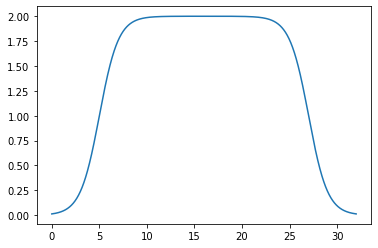

In [35]:
x = np.linspace(0,L,N+1)
d= 4 
w = 1
w_tanh_bound = torch.tensor(np.tanh((x-d)/w)-np.tanh((x-L+d)/w), device=device)
plt.plot(x,w_tanh_bound.cpu())


In [43]:
w0,w1=w_FMT()
w_torch_ini=np.random.randn(n_conv,2,conv_dim)*0.001
w_torch_ini[0] = [np.real(w0)/10,np.imag(w0)]  
w_torch_ini[1] = [np.real(w1)/10,np.imag(w1)]

[dense_layer_0_ini,dense_layer_ini]=[np.random.randn(n_dim1,n_conv)*0.001,
                                     np.random.randn(n_layer-1,n_dim1,n_dim1p)*0.001]

In [44]:
load_weight = False
if(load_weight==True):
    w_torch_ini,dense_layer_0_ini,dense_layer_ini=load_model()

In [45]:

w_torch = torch.tensor(w_torch_ini, requires_grad=True, device=device)

dense_layer_0=torch.tensor(dense_layer_0_ini, dtype=torch.float64, requires_grad=True, device=device)
dense_layer=torch.tensor(dense_layer_ini, dtype=torch.float64, requires_grad=True, device=device)


In [46]:
kill=0
fed = final_equation()
fed;

In [47]:
log=open("log_loss.dat", "w")
log.close()

In [ ]:
alpha1=0.9
alpha2=0.1
#asym = 10**-3

for phase in range (1,4):
    if(phase==1):
        conv_penalty=0
        dense_penalty=0
        kill = 0
        n_epochs=1000
        lr=10**-3
        asym=10**-5
    
    if(phase==2):
        conv_penalty=0
        dense_penalty=10**-3
        kill = 0.05
        n_epochs=20000
        lr=10**-3
        asym=10**-3
        
    if(phase==3):
        conv_penalty=0
        dense_penalty=0
        kill = 0.1
        n_epochs=1000
        lr=10**-3
        asym=10**-3
        
    MAE = torch.nn.L1Loss()
    optimizer = torch.optim.Adam([w_torch,dense_layer_0,dense_layer],lr=lr)
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs+1):
        start=time.time()
        loss_batch=[]
        for rho_batch, Vext_batch,mu_batch in train_loader:
            rho_batch=rho_batch.to(device)
            Vext_batch=Vext_batch.to(device)
            mu_batch=mu_batch.to(device)
            rhoMLs,muMLs,w_sym=FEQL(rho_batch,Vext_batch,kill)
            loss = MAE(rhoMLs,rho_batch)+alpha2*MAE(muMLs,mu_batch)+\
                    conv_penalty*MAE(w_torch,torch.zeros_like(w_torch))+asym*w_sym+\
                    dense_penalty*(MAE(dense_layer_0,torch.zeros_like(dense_layer_0))+
                                   MAE(dense_layer,torch.zeros_like(dense_layer)))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_batch.append(loss.data.cpu().numpy())
        train_losses.append(np.mean(loss_batch))
        #save_model()
        loss_batch=[]
        for rho_batch,Vext_batch,mu_batch in val_loader:
            rho_batch=rho_batch.to(device)
            Vext_batch=Vext_batch.to(device)
            mu_batch=mu_batch.to(device)
            rhoMLs,muMLs,w_sym = FEQL(rho_batch,Vext_batch,kill)
            loss = MAE(rhoMLs,rho_batch)+alpha2*MAE(muMLs,mu_batch)+\
                    conv_penalty*MAE(w_torch,torch.zeros_like(w_torch))+asym*w_sym+\
                    dense_penalty*(MAE(dense_layer_0,torch.zeros_like(dense_layer_0))+
                                   MAE(dense_layer,torch.zeros_like(dense_layer)))
            loss_batch.append(loss.data.cpu().numpy())
        val_losses.append(np.mean(loss_batch))
        end=time.time()
        log=open("log_loss.dat", "a")
        log.write("loss = "+str(train_losses[-1])+",\t val loss = "+str(val_losses[-1])+"\n")
        log.close()
        save_model()
        print("time ",end-start,"s ","\tepoch=",epoch,"/",n_epochs,"\t loss = ",train_losses[-1],"\t val loss = ",val_losses[-1])
    save_model()
        

time  6.817176818847656 s  	epoch= 0 / 1000 	 loss =  0.3832187137723305 	 val loss =  0.3864671088487559


In [ ]:
filename = 'final_eq.dat'
outfile = open(filename,'rb')
final_fed = pickle.load(outfile)
outfile.close()
final_fed

In [ ]:
def convert_w_to_np(w):
    w_res = w.data.cpu().numpy()
    w_res = (w_res[0]+w_res[1]*1j)
    return w_res

In [ ]:
w1_result = convert_w_to_np(w_torch[1])
plt.plot(np.fft.irfft(w_torch_ini[0][0]+w_torch_ini[0][1]*1j),"b-")
plt.plot(np.fft.irfft(w1_result),"k--")

In [ ]:
w1_result = convert_w_to_np(w_torch[1])
plt.plot(np.fft.irfft(w_torch_ini[0][0]+w_torch_ini[0][1]*1j)-np.fft.irfft(w1_result),"b-")

In [ ]:
plt.plot(w_torch_ini[1][0]-np.real(w1_result),"b-")

In [ ]:
a=torch.ones(1024)*2
b=torch.ones(2,1024)

In [ ]:
a*b